In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize

def read_files(files):
    data = []
    for f in files:
        data += [pd.read_csv(f, sep=',', skipinitialspace=True)]
    return data

In [2]:
def fit(f, par, x, y):
    """Аргументы:
    f - функция, которую мы хотим оптимизировать.
    params - начальное состояние параметров, можно просто передать нули,
    главное чтоб их было нужное количество
    x, y - точки, под которые подгоняем функцию
    """
    if len(x) != len(y):
        raise "Иксов должно быть столько же, сколько и игреков"
    def err(par, x_, y_):
        y1 = f(par, x_)
        return np.sum((y1-y_)**2)
    return minimize(err, [par], args=(x, y)).x[0]

In [3]:
def latex_tab(df, caption):
    tab = df.to_latex(float_format='%.3f',
                      caption=caption,
                      escape=False,
                      index=False,
                      position='H')

    tab = tab.replace('\\\\\n', '\\\\ \\hline\n')
    tab = tab.replace('I(mA)', r'$I$, мА')
    tab = tab.replace('U(V)', r'$U$, В')
    tab = tab.replace('Q &', r'$Q$, мВт &')
    tab = tab.replace('R &', r'$R$, Ом &')
    tab = tab.replace('\\toprule', '\\hline')
    tab = tab.replace('\\midrule\n', '')
    tab = tab.replace('rrrrrr', '|c|c|c|c|c|c|')
    tab = tab.replace('\\bottomrule\n', '')
    return tab


In [4]:
# Давления в 1 п. лабы

P_lim = [69.45, 4304.46]
P_atm = 99.71 * 1e3

inv_P = [1 / P_lim[1] + i / 6 * (1 / P_lim[0] - 1 / P_lim[1]) for i in range(7)]
inv_P += [1 / P_atm + i / 4 * (1 / P_lim[1] - 1 / P_atm) for i in range(4)]
P = [1 / p for p in inv_P]
P.sort()
P

[69.45,
 83.0719363645837,
 103.34132342824749,
 136.694512232762,
 201.83695244139577,
 385.5933585713642,
 4304.46,
 5657.8637324185265,
 8252.654613598917,
 15243.64502645898,
 99710.0]

In [198]:
FIGSIZE = (8, 4)

In [199]:
[load] = read_files(['data/QR.csv'])

I = load['I(mA)']
U = load['U(V)']

# Ток и напряжение
R = 1e3 * U / I
Q = U * I

load['R'] = R
load['Q'] = Q

rel_err = np.sqrt((0.001 / I)**2 + (0.001 / U)**2)
R_err = R * rel_err
Q_err = Q * rel_err

x_ax = np.linspace(0, max(Q), 1000)
[A, B], cov = np.polyfit(Q, R, deg=1, cov=True)
cov = np.sqrt(np.diag(cov))
A_err = cov[0]
B_err = cov[1]

In [200]:
B_err / B

0.0006049370588530067

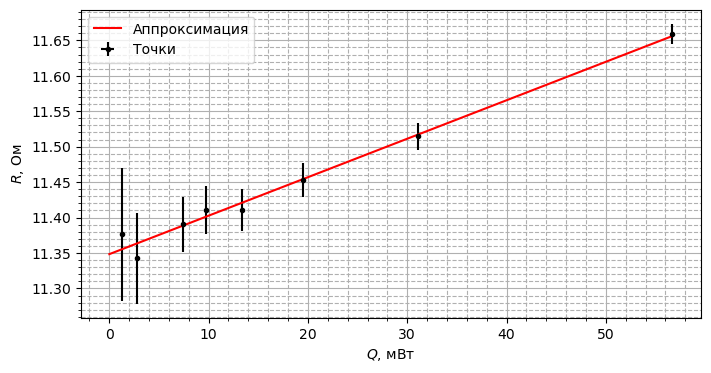

In [201]:
plt.figure(figsize=FIGSIZE)
plt.minorticks_on()

plt.errorbar(Q, R, fmt='k.', label='Точки', xerr=Q_err, yerr=R_err)
plt.plot(x_ax, A * x_ax + B, label='Аппроксимация', color='red')

plt.xlabel('$Q$, мВт')
plt.ylabel('$R$, Ом')

plt.grid(which='major')
plt.grid(which='minor', linestyle='--')
plt.legend()
plt.savefig('graphs/QR.pdf')

In [202]:
ALPHA = 3.92e-3
T_K = 25

R_k = B
R_k

11.348375455934322

In [203]:
R0 = R_k / (1 + ALPHA * T_K)
R0

10.33549677225348

In [204]:
def plot_press(press, name, colors, fmts):
    plt.figure(figsize=FIGSIZE)
    plt.minorticks_on()

    A = []
    B = []

    for i in range(len(press)):
        [data] = read_files([f'data/UI{press[i]}.csv'])
        U = data['U(V)']
        I = data['I(mA)']
        rel_err = np.sqrt((0.001 / I)**2 + (0.001 / U)**2)

        T = ((1e3 * U / I) / R0 - 1) / ALPHA
        T_err = T * rel_err
        Q = U * I
        Q_err = Q * rel_err
        [a, b], cov = np.polyfit(Q, T, deg=1, cov=True)
        cov = np.sqrt(np.diag(cov))
        A.append(a)
        B.append(b)

        x_ax = np.linspace(0, 60, 1000)

        plt.errorbar(Q, T, fmt=fmts[i], xerr=Q_err, yerr=T_err)
        plt.plot(x_ax, a * x_ax + b, label=f'$P = {press[i]: .0f}$ Па', color=colors[i])

    plt.xlabel('$Q$, мВт')
    plt.ylabel('$T, ^{\circ}$C')

    plt.grid(which='major')
    plt.grid(which='minor', linestyle='--')
    plt.legend()
    plt.savefig(f'graphs/QT_{name}.pdf')

    return A

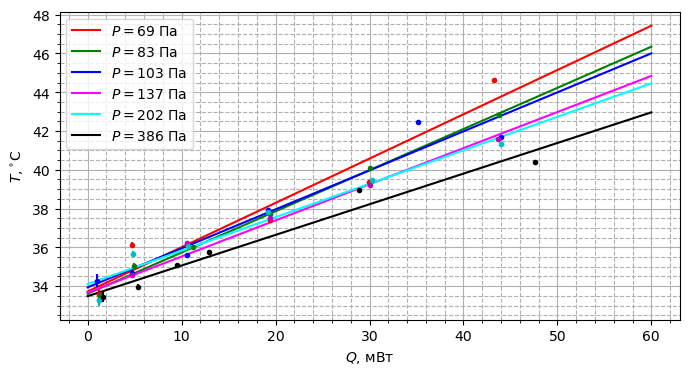

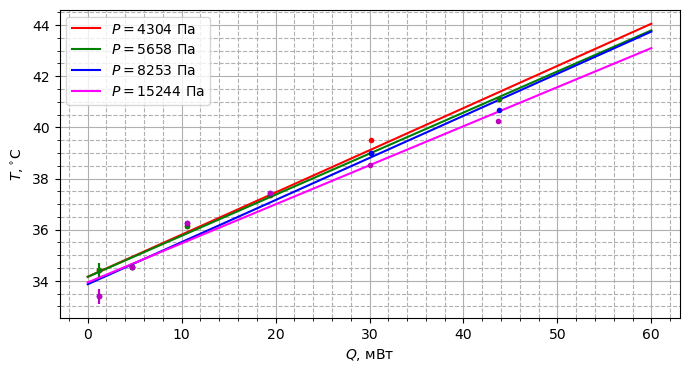

In [205]:
low_press = P[:6]
high_press = P[6:10]
press = low_press + high_press

colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'black']
fmts = ['r.', 'g.', 'b.', 'm.', 'c.', 'k.']

k_low = plot_press(low_press, 'lowpress', colors, fmts)
k_high = plot_press(high_press, 'highpress', colors, fmts)
k_all = k_low + k_high

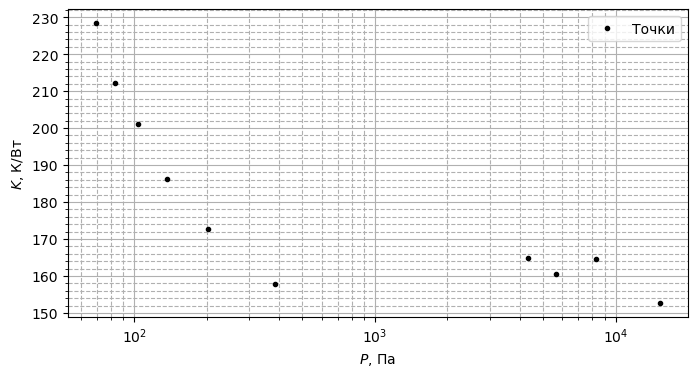

In [206]:
for i in range(len(k_all)):
    k_all[i] *= 1e3

plt.figure(figsize=FIGSIZE)
plt.minorticks_on()
plt.xscale('log')
plt.errorbar(press, k_all, fmt='k.', label='Точки')
plt.xlabel('$P$, Па')
plt.ylabel('$K$, К/Вт')
plt.legend()

plt.grid(which='major')
plt.grid(which='minor', linestyle='--')
plt.savefig('graphs/KP.pdf')

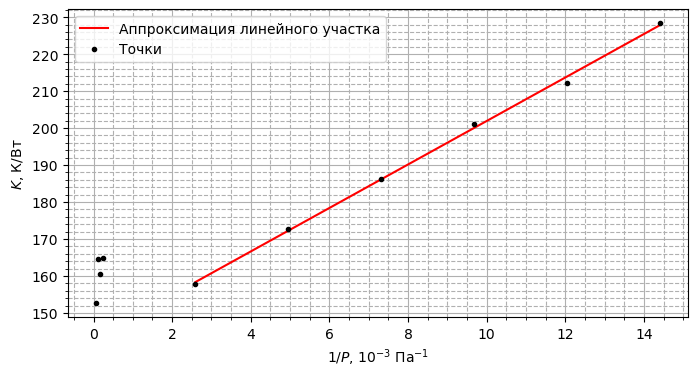

In [207]:
plt.figure(figsize=FIGSIZE)
plt.minorticks_on()

inv_P = [1e3 / p for p in press]

[A, B] = np.polyfit(inv_P[:6], k_all[:6], deg=1)
x_ax = np.linspace(min(inv_P[:6]), max(inv_P[:6]), 1000)

plt.errorbar(inv_P, k_all, fmt='k.', label='Точки')
plt.plot(x_ax, A * x_ax + B, color='red', label='Аппроксимация линейного участка')
plt.xlabel('$1 / P$, $10^{-3}$ Па$^{-1}$')
plt.ylabel('$K$, К/Вт')
plt.legend()

plt.grid(which='major')
plt.grid(which='minor', linestyle='--')
plt.savefig('graphs/KP_lin.pdf')